<a href="https://colab.research.google.com/github/brunoleomenezes/MC-CD05/blob/main/01_LNCC_bruno_MC_CD05_090226.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**Large Language Models - MC-CD05**
*Professor: Bruno Menezes e Daniel Senna (LNCC)*

#Núcleo do Transformer: atenção, embeddings e normalização.

In [ ]:
# ============================================================
# COLAB DEMO — NÚCLEO DO TRANSFORMER
# BERT (bidirecional)
#
# Objetivo:
# - Mostrar como o Transformer transforma palavras em vetores inteligentes:
#   * quem eu sou        -> token embeddings
#   * onde eu estou     -> position embeddings
#   * com quem me importo -> self-attention
# - Começar com BERT (atenção bidirecional, mais didática)
#
# ============================================================

# -----------------------------
# CÉLULA 1 — Instalar dependências
# -----------------------------
!pip -q install transformers accelerate

In [ ]:
# -----------------------------
# CÉLULA 2 — Imports
# -----------------------------
import time                                # Medição de tempo
import torch                               # Tensores e execução em CPU/GPU
import numpy as np                         # Operações numéricas
import matplotlib.pyplot as plt            # Visualização das matrizes de atenção
from transformers import (
    AutoTokenizer,
    AutoModel,
    AutoModelForCausalLM
)

In [ ]:
# -----------------------------
# CÉLULA 3 — Seleção de dispositivo
# -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [ ]:
# ============================================================
# PARTE A — BERT (TRANSFORMER BIDIRECIONAL)
# ============================================================

# -----------------------------
# CÉLULA 4 — Carregar tokenizer e modelo BERT
# -----------------------------
bert_name = "bert-base-uncased"                            # Modelo encoder bidirecional
bert_tokenizer = AutoTokenizer.from_pretrained(bert_name)  # Tokenizer WordPiece
bert_model = AutoModel.from_pretrained(bert_name)          # BERT base (sem head)
bert_model.to(device)                                      # Move para GPU/CPU
bert_model.eval()                                          # Modo avaliação

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [ ]:
# -----------------------------
# CÉLULA 5 — Texto de exemplo
# -----------------------------
text = "A cute teddy bear is reading a book."
print("\n[BERT] Input text:", text)



[BERT] Input text: A cute teddy bear is reading a book.


In [ ]:
# -----------------------------
# CÉLULA 6 — Tokenização (BERT)
# -----------------------------
# Aplica o tokenizer do BERT ao texto bruto.
# Nesta etapa o texto é:
#  - normalizado (minúsculas, pois o modelo é uncased)
#  - segmentado em WordPieces
#  - enriquecido com tokens especiais [CLS] (início) e [SEP] (fim)
#  - convertido em tensores PyTorch
bert_inputs = bert_tokenizer(text, return_tensors="pt")

# Extrai os IDs numéricos dos tokens.
# Cada número corresponde a um token no vocabulário fixo do BERT.
# Shape: [batch_size, seq_len]
bert_input_ids = bert_inputs["input_ids"].to(device)

# Extrai a máscara de atenção.
# Valor 1 indica token válido; valor 0 indicaria padding.
# Essa máscara será usada para impedir que o modelo atenda posições inexistentes.
bert_attention_mask = bert_inputs["attention_mask"].to(device)

# Converte os IDs numéricos de volta para tokens legíveis.
# Isso NÃO é usado no modelo, apenas para inspeção didática.
# Permite visualizar:
#  - tokens especiais ([CLS], [SEP])
#  - possíveis quebras em subpalavras
bert_tokens = bert_tokenizer.convert_ids_to_tokens(
    bert_input_ids[0].tolist()
)

# Imprime os tokens que efetivamente entram no Transformer BERT.
# O índice de cada token corresponde às linhas/colunas das matrizes de atenção.
print("[BERT] Tokens:")

# Itera sobre os tokens, exibindo posição e símbolo textual.
# Essa numeração será usada depois para interpretar mapas de self-attention.
for i, t in enumerate(bert_tokens):
    print(f"{i:02d}  {t}")



[BERT] Tokens:
00  [CLS]
01  a
02  cute
03  teddy
04  bear
05  is
06  reading
07  a
08  book
09  .
10  [SEP]


In [ ]:
# ============================================================
# CÉLULA 6.1 — Prints tokenização BERT
# ============================================================

print("\n==============================")
print("[PRINT 1] Texto de entrada")
print("==============================")
print(text)

print("\n==============================")
print("[PRINT 2] Tokens gerados pelo BERT (WordPiece)")
print("==============================")
for i, t in enumerate(bert_tokens):
    print(f"{i:02d}  {t}")

print("\n==============================")
print("[PRINT 3] input_ids (IDs numéricos dos tokens)")
print("==============================")
print("Shape:", tuple(bert_input_ids.shape))
print(bert_input_ids)

print("\n==============================")
print("[PRINT 4] attention_mask (tokens válidos)")
print("==============================")
print("Shape:", tuple(bert_attention_mask.shape))
print(bert_attention_mask)

print("\n==============================")
print("[INTERPRETAÇÃO GUIADA]")
print("==============================")
print(
    "• Cada linha em input_ids representa um token do texto.\n"
    "• Os números são índices no vocabulário do BERT.\n"
    "• attention_mask = 1 indica token válido.\n"
    "• A posição do token define sua linha/coluna nas matrizes de self-attention.\n"
    "• Esses objetos são a única entrada real do Transformer."
)



[PRINT 1] Texto de entrada
A cute teddy bear is reading a book.

[PRINT 2] Tokens gerados pelo BERT (WordPiece)
00  [CLS]
01  a
02  cute
03  teddy
04  bear
05  is
06  reading
07  a
08  book
09  .
10  [SEP]

[PRINT 3] input_ids (IDs numéricos dos tokens)
Shape: (1, 11)
tensor([[  101,  1037, 10140, 11389,  4562,  2003,  3752,  1037,  2338,  1012,
           102]], device='cuda:0')

[PRINT 4] attention_mask (tokens válidos)
Shape: (1, 11)
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], device='cuda:0')

[INTERPRETAÇÃO GUIADA]
• Cada linha em input_ids representa um token do texto.
• Os números são índices no vocabulário do BERT.
• attention_mask = 1 indica token válido.
• A posição do token define sua linha/coluna nas matrizes de self-attention.
• Esses objetos são a única entrada real do Transformer.


In [ ]:
# -----------------------------
# CÉLULA 7 — Embeddings de entrada (quem + onde + segmento)
# -----------------------------
# Nesta célula, o texto deixa definitivamente de ser "palavra" e passa a ser
# uma sequência de vetores numéricos que o Transformer consegue processar.
#
# Todas as representações terão o formato:
# (batch_size, seq_len, hidden_size)
#
# No caso do BERT-base:
#  - batch_size = 1  (uma frase)
#  - seq_len    = número de tokens (inclui [CLS] e [SEP])
#  - hidden_size = 768 (dimensão do espaço vetorial do modelo)

with torch.no_grad():
    # Comprimento da sequência após a tokenização
    # Ex.: [CLS] a cute teddy bear is reading a book . [SEP] -> 11 tokens
    seq_len_bert = bert_input_ids.shape[1]

    # Cria os IDs de posição para cada token da sequência
    # Esses IDs informam ao modelo "onde eu estou" na frase
    # Shape: (1, seq_len)
    position_ids = torch.arange(seq_len_bert, device=device).unsqueeze(0)

    # Cria os IDs de segmento (token type IDs)
    # No BERT, eles servem para diferenciar frases A e B (ex.: pergunta/resposta)
    # Como aqui há apenas uma frase, todos os valores são zero
    # Shape: (1, seq_len)
    token_type_ids = torch.zeros_like(bert_input_ids)

    # Busca os embeddings dos tokens no vocabulário do BERT
    # Cada token ID é convertido em um vetor de 768 dimensões
    # Representa "quem eu sou" (significado lexical bruto)
    # Shape: (1, seq_len, 768)
    token_embeds = bert_model.embeddings.word_embeddings(bert_input_ids)

    # Busca os embeddings posicionais
    # Cada posição da sequência possui um vetor próprio
    # Representa "onde eu estou" na frase
    # Shape: (1, seq_len, 768)
    position_embeds = bert_model.embeddings.position_embeddings(position_ids)

    # Busca os embeddings de segmento
    # Indica a qual frase o token pertence (A ou B)
    # Aqui não adiciona informação semântica nova, mas faz parte da arquitetura
    # Shape: (1, seq_len, 768)
    segment_embeds = bert_model.embeddings.token_type_embeddings(token_type_ids)

    # Soma dos três tipos de embedding
    # Este tensor representa a entrada final do Transformer
    # Antes da aplicação de LayerNorm e Dropout
    #
    # Em termos conceituais:
    # token_embeds    -> "quem eu sou"
    # position_embeds -> "onde eu estou"
    # segment_embeds  -> "a qual frase pertenço"
    bert_input_embeds = token_embeds + position_embeds + segment_embeds

# Impressão das dimensões para inspeção didática
# Todas devem ter o mesmo formato (1, seq_len, 768)
print("\n[BERT] Shapes:")
print(" token_embeds    :", tuple(token_embeds.shape))
print(" position_embeds :", tuple(position_embeds.shape))
print(" segment_embeds  :", tuple(segment_embeds.shape))
print(" input_embeds    :", tuple(bert_input_embeds.shape))



[BERT] Shapes:
 token_embeds    : (1, 11, 768)
 position_embeds : (1, 11, 768)
 segment_embeds  : (1, 11, 768)
 input_embeds    : (1, 11, 768)


In [ ]:
print(" token_embeds    :", token_embeds)
print(" position_embeds :", position_embeds)
print(" segment_embeds  :", segment_embeds)
print(" input_embeds    :", bert_input_embeds)

 token_embeds    : tensor([[[ 0.0136, -0.0265, -0.0235,  ...,  0.0087,  0.0071,  0.0151],
         [ 0.0152,  0.0082,  0.0043,  ..., -0.0031, -0.0055,  0.0189],
         [-0.1190, -0.0111,  0.0389,  ..., -0.0407,  0.0097, -0.0232],
         ...,
         [ 0.0035, -0.0230,  0.0385,  ..., -0.0345, -0.0429, -0.0096],
         [-0.0207, -0.0020, -0.0118,  ...,  0.0128,  0.0200,  0.0259],
         [-0.0145, -0.0100,  0.0060,  ..., -0.0250,  0.0046, -0.0015]]],
       device='cuda:0')
 position_embeds : tensor([[[ 1.7505e-02, -2.5631e-02, -3.6642e-02,  ...,  3.3437e-05,
           6.8312e-04,  1.5441e-02],
         [ 7.7580e-03,  2.2613e-03, -1.9444e-02,  ...,  2.8910e-02,
           2.9753e-02, -5.3247e-03],
         [-1.1287e-02, -1.9644e-03, -1.1573e-02,  ...,  1.4908e-02,
           1.8741e-02, -7.3140e-03],
         ...,
         [ 2.0350e-03, -1.4569e-02, -1.4560e-02,  ...,  1.4465e-02,
           1.0401e-02,  3.7587e-03],
         [ 6.4402e-03, -3.3601e-03, -1.6502e-02,  ...,  2.5114

In [ ]:
# ------------------------------------------------------------
# INSPEÇÃO DOS EMBEDDINGS — LEITURA GUIADA DOS TENSORES
# ------------------------------------------------------------
# A partir daqui, estamos olhando diretamente para os vetores
# que representam os tokens no espaço interno do BERT.
#
# Cada tensor tem o formato:
# (batch_size = 1, seq_len = 11, hidden_size = 768)
#
# • batch_size = 1
#   Indica quantas sequências estão sendo processadas em paralelo.
#   Aqui temos apenas uma frase, mas em treino real esse valor pode ser 8, 16, 32, etc.
#   O Transformer sempre trabalha em batch, mesmo quando processa uma única frase.
#
# • seq_len = 11
#   Corresponde ao número total de tokens após a tokenização.
#   Inclui tokens especiais do BERT, como [CLS] (início) e [SEP] (fim).
#   Cada token ocupa uma posição fixa na sequência e terá um vetor próprio.
#
# • hidden_size = 768
#   É a dimensão do espaço vetorial interno do BERT-base.
#   Cada token é representado por um vetor de 768 números reais.
#   Esse valor é uma característica arquitetural do modelo (BERT-large usa 1024).
#
# Em resumo:
# Uma frase -> 11 tokens -> cada token vira um vetor 768D
# Esse tensor é a representação que alimenta todas as camadas do Transformer.
#
# Cada linha da dimensão seq_len corresponde a um token da frase.
# Cada vetor de 768 valores representa esse token em um espaço semântico.

# ------------------------------------------------------------
# token_embeds
# ------------------------------------------------------------
# Embedding lexical dos tokens ("quem eu sou").
#
# • Cada token ID busca um vetor fixo na tabela de embeddings do BERT.
# • Esses vetores NÃO dependem do contexto.
# • Ex.: o vetor de "teddy" aqui é o mesmo em qualquer frase.
# • Valores positivos e negativos não têm interpretação isolada:
#   o significado está no vetor como um todo (geometria).
print(" token_embeds    :", token_embeds)

# ------------------------------------------------------------
# position_embeds
# ------------------------------------------------------------
# Embedding posicional ("onde eu estou").
#
# • Cada posição da sequência (0, 1, 2, ...) possui um vetor próprio.
# • Dois tokens iguais em posições diferentes terão embeddings diferentes.
# • Esses vetores permitem ao Transformer distinguir ordem e distância.
# • Sem isso, a frase seria tratada como um conjunto sem ordem.
print(" position_embeds :", position_embeds)

# ------------------------------------------------------------
# segment_embeds
# ------------------------------------------------------------
# Embedding de segmento ("a qual frase eu pertenço").
#
# • Usado no BERT para diferenciar sentença A e sentença B
#   (ex.: pergunta vs resposta).
# • Como aqui há apenas uma frase, todos os vetores são iguais.
# • Apesar disso, o embedding ainda é somado por consistência arquitetural.
print(" segment_embeds  :", segment_embeds)

# ------------------------------------------------------------
# input_embeds
# ------------------------------------------------------------
# Embedding final de entrada do Transformer.
#
# • Resultado da soma:
#   token_embeds + position_embeds + segment_embeds
#
# • Este tensor é a representação completa do texto ANTES da atenção.
# • A partir daqui, o modelo NÃO enxerga mais palavras ou posições explícitas.
# • Tudo o que acontece nas camadas seguintes (Q, K, V, atenção, FFN)
#   opera exclusivamente sobre esses vetores.
print(" input_embeds    :", bert_input_embeds)


 token_embeds    : tensor([[[ 0.0136, -0.0265, -0.0235,  ...,  0.0087,  0.0071,  0.0151],
         [ 0.0152,  0.0082,  0.0043,  ..., -0.0031, -0.0055,  0.0189],
         [-0.1190, -0.0111,  0.0389,  ..., -0.0407,  0.0097, -0.0232],
         ...,
         [ 0.0035, -0.0230,  0.0385,  ..., -0.0345, -0.0429, -0.0096],
         [-0.0207, -0.0020, -0.0118,  ...,  0.0128,  0.0200,  0.0259],
         [-0.0145, -0.0100,  0.0060,  ..., -0.0250,  0.0046, -0.0015]]],
       device='cuda:0')
 position_embeds : tensor([[[ 1.7505e-02, -2.5631e-02, -3.6642e-02,  ...,  3.3437e-05,
           6.8312e-04,  1.5441e-02],
         [ 7.7580e-03,  2.2613e-03, -1.9444e-02,  ...,  2.8910e-02,
           2.9753e-02, -5.3247e-03],
         [-1.1287e-02, -1.9644e-03, -1.1573e-02,  ...,  1.4908e-02,
           1.8741e-02, -7.3140e-03],
         ...,
         [ 2.0350e-03, -1.4569e-02, -1.4560e-02,  ...,  1.4465e-02,
           1.0401e-02,  3.7587e-03],
         [ 6.4402e-03, -3.3601e-03, -1.6502e-02,  ...,  2.5114

## Uma representação visual

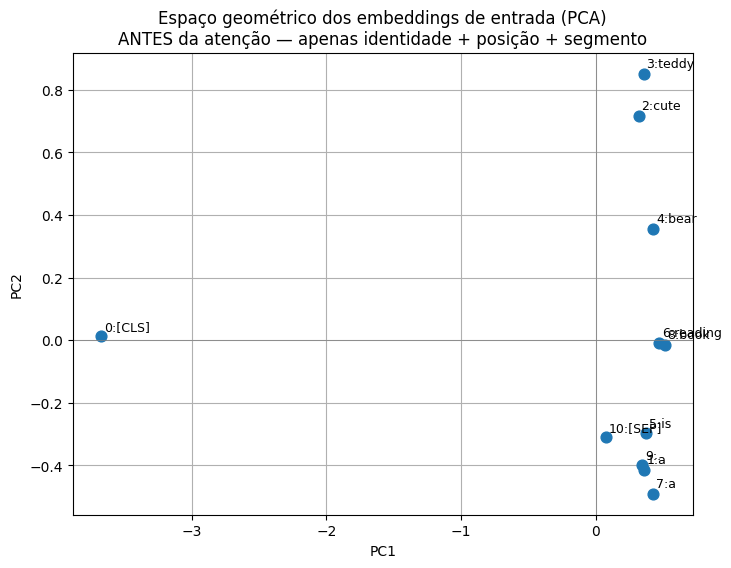

bert_attentions ainda não foi gerado.
Mostramos apenas a geometria dos embeddings.
Quando a atenção for introduzida, este mesmo código
passará automaticamente a exibir heatmap e setas.


In [ ]:
# ============================================================
# VISUALIZAÇÕES DIDÁTICAS — GEOMETRIA DOS EMBEDDINGS E ATENÇÃO
# ============================================================
# Este código cria visualizações progressivas:
#
# 1) Espaço geométrico dos embeddings (PCA)
# 2) (Opcional) Heatmap de atenção
# 3) (Opcional) Setas de atenção sobre o espaço geométrico
#
# IMPORTANTE (didático):
# • Se bert_attentions NÃO existir ainda, apenas a geometria é exibida
# • Isso permite explicar primeiro "onde os tokens estão"
# • A atenção entra somente quando você decidir
# ============================================================

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# ------------------------------------------------------------
# PREPARAÇÃO DOS DADOS
# ------------------------------------------------------------
# bert_input_embeds: (1, seq_len, 768)
# Removemos batch → (seq_len, 768)

X = bert_input_embeds[0].detach().cpu().numpy()
seq_len = X.shape[0]

# ------------------------------------------------------------
# 1) PROJEÇÃO GEOMÉTRICA (PCA)
# ------------------------------------------------------------
# PCA NÃO faz parte do Transformer.
# Ele serve apenas para reduzir 768D → 2D
# para permitir visualização humana.

pca = PCA(n_components=2)
X_2d = pca.fit_transform(X)

plt.figure(figsize=(8, 6))

# Cada token vira um ponto
plt.scatter(X_2d[:, 0], X_2d[:, 1], s=60, zorder=2)

# Rótulos dos tokens
for i, token in enumerate(bert_tokens):
    plt.text(
        X_2d[i, 0] + 0.02,
        X_2d[i, 1] + 0.02,
        f"{i}:{token}",
        fontsize=9
    )

plt.axhline(0, color="gray", linewidth=0.5)
plt.axvline(0, color="gray", linewidth=0.5)

plt.title(
    "Espaço geométrico dos embeddings de entrada (PCA)\n"
    "ANTES da atenção — apenas identidade + posição + segmento"
)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()

# ------------------------------------------------------------
# MENSAGEM PEDAGÓGICA (para você verbalizar):
#
# • Cada ponto = um token
# • Distância = relação geométrica
# • NÃO existe inteligência ainda
# • Não há contexto, só posição no espaço
# ------------------------------------------------------------


# ============================================================
# A PARTIR DAQUI: ATENÇÃO (SE JÁ ESTIVER DISPONÍVEL)
# ============================================================

if "bert_attentions" in globals():

    # --------------------------------------------------------
    # 2) HEATMAP DE SELF-ATTENTION
    # --------------------------------------------------------

    layer = len(bert_attentions) - 1   # última camada
    head = 0                           # primeira cabeça

    # (seq_len, seq_len)
    att = bert_attentions[layer][0, head].detach().cpu().numpy()

    plt.figure(figsize=(8, 7))
    plt.imshow(att, aspect="auto", cmap="viridis")
    plt.colorbar(label="Peso de atenção")

    plt.xticks(range(seq_len), bert_tokens, rotation=90)
    plt.yticks(range(seq_len), bert_tokens)

    plt.xlabel("Keys (tokens observados)")
    plt.ylabel("Queries (token que pergunta)")

    plt.title(
        f"Heatmap de Self-Attention\n"
        f"Camada {layer}, Cabeça {head}\n"
        f"(cada linha soma 1)"
    )

    plt.tight_layout()
    plt.show()

    # --------------------------------------------------------
    # INTERPRETAÇÃO PEDAGÓGICA:
    #
    # • Cada linha responde: "Para quem EU olho?"
    # • Cada coluna responde: "Quem está me observando?"
    # • Atenção é decisão LOCAL de cada token
    # --------------------------------------------------------


    # --------------------------------------------------------
    # 3) SETAS DE ATENÇÃO SOBRE O ESPAÇO GEOMÉTRICO
    # --------------------------------------------------------

    top_k = 2
    min_weight = 0.12

    plt.figure(figsize=(8, 6))

    # Pontos
    plt.scatter(X_2d[:, 0], X_2d[:, 1], s=60, zorder=2)

    # Rótulos
    for i, token in enumerate(bert_tokens):
        plt.text(
            X_2d[i, 0] + 0.02,
            X_2d[i, 1] + 0.02,
            f"{i}:{token}",
            fontsize=9
        )

    # Setas de atenção
    for i in range(seq_len):
        idx = np.argsort(-att[i])[:top_k]

        for j in idx:
            w = att[i, j]

            if w >= min_weight and i != j:
                plt.arrow(
                    X_2d[i, 0],
                    X_2d[i, 1],
                    X_2d[j, 0] - X_2d[i, 0],
                    X_2d[j, 1] - X_2d[i, 1],
                    alpha=w,
                    width=0.003,
                    head_width=0.05,
                    length_includes_head=True,
                    color="black",
                    zorder=1
                )

    plt.axhline(0, color="gray", linewidth=0.5)
    plt.axvline(0, color="gray", linewidth=0.5)

    plt.title(
        f"Fluxo de Atenção sobre o Espaço Geométrico\n"
        f"Camada {layer}, Cabeça {head}\n"
        f"(setas = decisões de informação)"
    )

    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.grid(True)
    plt.show()

    # --------------------------------------------------------
    # • Pontos NÃO são inteligentes
    # • Setas criam dependência contextual
    # • Vetores finais = soma ponderada dos vetores observados
    #
    # A inteligência está nas conexões.
    # --------------------------------------------------------

else:
    print(
        "bert_attentions ainda não foi gerado.\n"
        "Mostramos apenas a geometria dos embeddings.\n"
        "Quando a atenção for introduzida, este mesmo código\n"
        "passará automaticamente a exibir heatmap e setas."
    )


In [ ]:
# -----------------------------
# CÉLULA 8 — Forward do BERT com attentions
# -----------------------------
# Objetivo desta célula:
# 1) Rodar o BERT "de verdade" (forward pass) com a frase já tokenizada
# 2) Pedir que ele devolva, além dos vetores finais, as matrizes de atenção internas
# 3) Guardar essas matrizes para visualizar e inspecionar

# torch.no_grad() = modo "somente inferência"
# (não calcula gradientes e não prepara nada para treino)
# Isso deixa mais rápido e economiza memória.
with torch.no_grad():

    # bert_model(...) executa todas as camadas do BERT.
    # Nós passamos:
    # - input_ids: os IDs numéricos dos tokens (a entrada real do modelo)
    # - attention_mask: 1 para tokens válidos e 0 para padding (aqui quase sempre tudo 1)
    # - output_attentions=True: pede para o BERT retornar também as atenções internas
    # - return_dict=True: retorna um objeto "organizado" (com campos nomeados)
    bert_outputs = bert_model(
        input_ids=bert_input_ids,
        attention_mask=bert_attention_mask,
        output_attentions=True,   # IMPORTANTÍSSIMO: sem isso, não recebemos as atenções
        return_dict=True
    )

# bert_outputs é um "pacote" com vários resultados.
# Um dos campos é .attentions
# Ele contém uma lista, uma por camada, com as matrizes de atenção.
bert_attentions = bert_outputs.attentions

# Quantas camadas o BERT-base tem? Normalmente 12.
print("\n[BERT] Número de camadas:", len(bert_attentions))

# Shape da atenção em UMA camada:
# Geralmente: [batch, heads, seq_len, seq_len]
# - batch: quantas frases (aqui 1)
# - heads: quantas cabeças de atenção (ex.: 12)
# - seq_len: número de tokens (inclui [CLS] e [SEP])
# - seq_len: novamente, porque cada token pode "olhar" para todos os tokens
print("[BERT] Shape da atenção (camada 0):", tuple(bert_attentions[0].shape))
# Exemplo esperado: (1, 12, 11, 11)

BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.



[BERT] Número de camadas: 12
[BERT] Shape da atenção (camada 0): (1, 12, 11, 11)


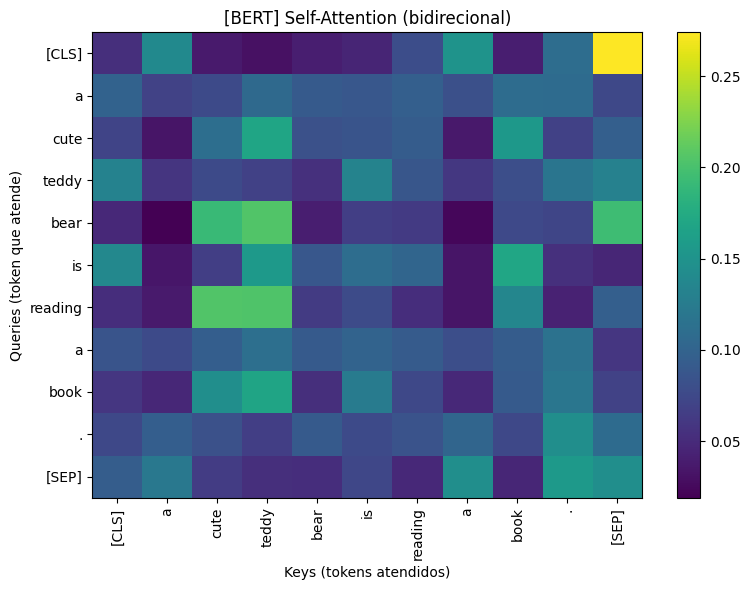

In [ ]:
# -----------------------------
# CÉLULA 9 — Visualização da atenção (BERT)
# -----------------------------
# Como existem muitas atenções (várias camadas e várias cabeças),
# escolhemos UMA camada e UMA cabeça para visualizar primeiro.

bert_layer = 0   # camada 0 = primeira camada do BERT
bert_head = 0    # cabeça 0 = primeira cabeça

# Agora extraímos UMA matriz 2D (seq_len x seq_len)
# bert_attentions[bert_layer]      -> todas as atenções da camada escolhida
# [0, bert_head]                   -> batch 0 (primeira frase) e a cabeça escolhida
# .cpu().numpy()                   -> traz para CPU e converte para numpy (para plotar)
att = bert_attentions[bert_layer][0, bert_head].cpu().numpy()

# Plot do heatmap:
# - Eixo X: tokens "observados" (keys)
# - Eixo Y: token que está "olhando" (query)
# Cada linha mostra "para quem esse token dá atenção".
plt.figure(figsize=(8, 6))
plt.imshow(att, aspect="auto")
plt.title("[BERT] Self-Attention (bidirecional)")
plt.xlabel("Keys (tokens atendidos)")
plt.ylabel("Queries (token que atende)")
plt.xticks(range(len(bert_tokens)), bert_tokens, rotation=90)
plt.yticks(range(len(bert_tokens)), bert_tokens)
plt.colorbar()          # barra de cores = intensidade do peso de atenção
plt.tight_layout()
plt.show()

In [ ]:
# -----------------------------
# CÉLULA 10 — Top-k atenções de um token (BERT)
# -----------------------------
# Além de ver o mapa inteiro, vamos escolher UM token e listar
# para quais tokens ele mais "olha" (maiores pesos na linha dele).

target_pos = 3  # posição do token escolhido na sequência (ex.: 3 pode ser "teddy")
k = 5           # quantos tokens mais atendidos queremos listar

# row = a linha da matriz de atenção correspondente ao token target_pos
# Essa linha é uma lista de pesos: um peso para cada token da frase.
row = att[target_pos]

# argsort(-row) ordena os índices do maior peso para o menor.
# Pegamos só os k primeiros índices.
top_idx = np.argsort(-row)[:k]

# Imprime o token alvo e os tokens mais atendidos por ele
print(f"\n[BERT] Token '{bert_tokens[target_pos]}' atende mais para:")
for j in top_idx:
    print(f"  -> pos {j:02d} '{bert_tokens[j]}'  peso={row[j]:.4f}")


[BERT] Token 'teddy' atende mais para:
  -> pos 05 'is'  peso=0.1333
  -> pos 00 '[CLS]'  peso=0.1318
  -> pos 10 '[SEP]'  peso=0.1311
  -> pos 09 '.'  peso=0.1176
  -> pos 06 'reading'  peso=0.0869


# Variações modernas: Mixture of Experts (MoE), Rotary Embeddings e Attention Scaling (visão sintética e aplicada).

In [ ]:
# ============================================================
# VARIAÇÕES MODERNAS DO TRANSFORMER
# Mixture of Experts (MoE), Rotary Embeddings e Attention Scaling
#
# Continuação direta do notebook:
# "Núcleo do Transformer: atenção, embeddings e normalização"
# ============================================================

# -----------------------------
# CÉLULA 1 — Dependências
# -----------------------------
!pip -q install torch numpy matplotlib

# -----------------------------
# CÉLULA 2 — Imports
# -----------------------------
import math
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [ ]:
# ============================================================
# CÉLULA 0 — CONTINUIDADE DIDÁTICA
# Reuso explícito do exemplo do núcleo
# ============================================================

# Tokens simbólicos (mesmo espírito do mini-corpus anterior)
tokens = ["teddy", "bear", "reads"]

# Embeddings toy (d_model = 4, dois pares para RoPE)
X = torch.tensor([
    [ 1.0,  0.0,  1.0,  0.0],   # teddy
    [ 1.0,  1.0,  0.0,  1.0],   # bear
    [ 0.0,  1.0, -1.0,  1.0],   # reads
], device=device)

print("[CONTINUIDADE] Tokens:", tokens)
print("[CONTINUIDADE] Embeddings base X:\n", X)

# Para foco conceitual:
Q = X.clone()
K = X.clone()
V = X.clone()

positions = torch.arange(len(tokens), device=device)

[CONTINUIDADE] Tokens: ['teddy', 'bear', 'reads']
[CONTINUIDADE] Embeddings base X:
 tensor([[ 1.,  0.,  1.,  0.],
        [ 1.,  1.,  0.,  1.],
        [ 0.,  1., -1.,  1.]], device='cuda:0')


In [ ]:
# ============================================================
# PARTE 1 — ROTARY POSITIONAL EMBEDDINGS (RoPE)
# ============================================================

# -----------------------------
# CÉLULA 3 — Rotação 2D explícita
# -----------------------------
def rot2d(x, theta):
    c = math.cos(theta)
    s = math.sin(theta)
    x1, x2 = x[..., 0], x[..., 1]
    y1 = x1 * c - x2 * s
    y2 = x1 * s + x2 * c
    return torch.stack([y1, y2], dim=-1)

# Demonstração geométrica simples
theta = math.pi / 6  # 30 graus
demo = torch.tensor([[1.0, 0.0], [1.0, 1.0]], device=device)

print("\n[RoPE 2D] x:\n", demo)
print("[RoPE 2D] theta:", theta)
print("[RoPE 2D] rot(x):\n", rot2d(demo, theta))


[RoPE 2D] x:
 tensor([[1., 0.],
        [1., 1.]], device='cuda:0')
[RoPE 2D] theta: 0.5235987755982988
[RoPE 2D] rot(x):
 tensor([[0.8660, 0.5000],
        [0.3660, 1.3660]], device='cuda:0')


In [ ]:
# -----------------------------
# CÉLULA 4 — RoPE generalizado (dimensão par)
# -----------------------------
def rope_apply(q_or_k, positions, base=10000.0):
    d = q_or_k.shape[-1]
    assert d % 2 == 0, "Dimensão deve ser par"

    i = torch.arange(0, d, 2, device=q_or_k.device).float()
    inv_freq = 1.0 / (base ** (i / d))

    angles = positions[:, None].float() * inv_freq[None, :]
    cos = torch.cos(angles)
    sin = torch.sin(angles)

    x1 = q_or_k[:, 0::2]
    x2 = q_or_k[:, 1::2]

    y1 = x1 * cos - x2 * sin
    y2 = x1 * sin + x2 * cos

    out = torch.empty_like(q_or_k)
    out[:, 0::2] = y1
    out[:, 1::2] = y2
    return out

Qr = rope_apply(Q, positions)
Kr = rope_apply(K, positions)

print("\n[RoPE] Q original:\n", Q)
print("[RoPE] Q rotacionado:\n", Qr)


[RoPE] Q original:
 tensor([[ 1.,  0.,  1.,  0.],
        [ 1.,  1.,  0.,  1.],
        [ 0.,  1., -1.,  1.]], device='cuda:0')
[RoPE] Q rotacionado:
 tensor([[ 1.0000,  0.0000,  1.0000,  0.0000],
        [-0.3012,  1.3818, -0.0100,  0.9999],
        [-0.9093, -0.4161, -1.0198,  0.9798]], device='cuda:0')



[ATENÇÃO] Logits sem RoPE:
 tensor([[ 1.0000,  0.5000, -0.5000],
        [ 0.5000,  1.5000,  1.0000],
        [-0.5000,  1.0000,  1.5000]], device='cuda:0')
[ATENÇÃO] Logits com RoPE:
 tensor([[ 1.0000, -0.1556, -0.9645],
        [-0.1556,  1.5000,  0.3444],
        [-0.9645,  0.3444,  1.5000]], device='cuda:0')


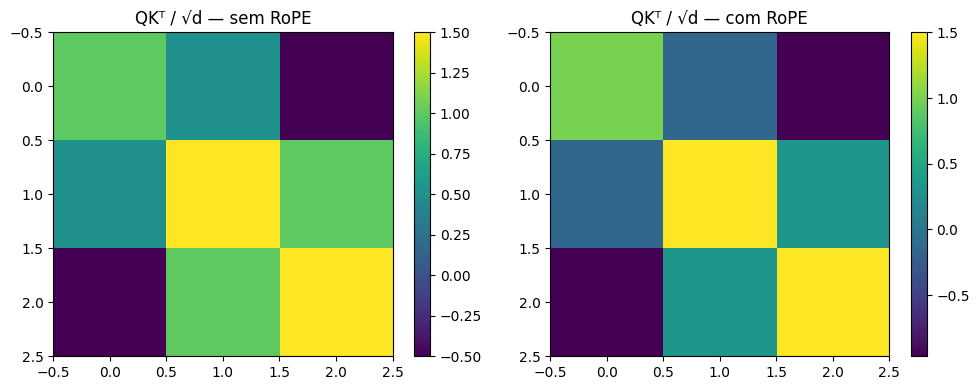

In [ ]:
# -----------------------------
# CÉLULA 5 — Logits antes e depois do RoPE
# -----------------------------
def attn_logits(Q, K):
    d = Q.shape[-1]
    return (Q @ K.T) / math.sqrt(d)

logits_plain = attn_logits(Q, K)
logits_rope  = attn_logits(Qr, Kr)

print("\n[ATENÇÃO] Logits sem RoPE:\n", logits_plain)
print("[ATENÇÃO] Logits com RoPE:\n", logits_rope)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(logits_plain.cpu(), aspect="auto")
plt.title("QKᵀ / √d — sem RoPE")
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(logits_rope.cpu(), aspect="auto")
plt.title("QKᵀ / √d — com RoPE")
plt.colorbar()

plt.tight_layout()
plt.show()

In [ ]:
# ============================================================
# PARTE 2 — ATTENTION SCALING E TEMPERATURA
# ============================================================

# -----------------------------
# CÉLULA 6 — Softmax estável
# -----------------------------
def softmax(x):
    x = x - x.max(dim=-1, keepdim=True).values
    ex = torch.exp(x)
    return ex / ex.sum(dim=-1, keepdim=True)

# Usamos uma linha REAL de atenção (token "teddy")
row = logits_plain[0]

print("\n[BASE] Logits reais:", row.tolist())


[BASE] Logits reais: [1.0, 0.5, -0.5]


In [ ]:
# -----------------------------
# CÉLULA 7 — Efeito da escala
# -----------------------------
scales = [0.5, 1.0, 2.0, 4.0]
for s in scales:
    p = softmax(s * row)
    ent = -(p * torch.log(p + 1e-12)).sum().item()
    print(f"[scale={s}] softmax={p.cpu().numpy()}  entropy={ent:.4f}")


[scale=0.5] softmax=[0.444214   0.3459542  0.20983183]  entropy=1.0553
[scale=1.0] softmax=[0.5465494  0.33149895 0.12195165]  entropy=0.9528
[scale=2.0] softmax=[0.7053845  0.25949648 0.03511902]  entropy=0.7139
[scale=4.0] softmax=[0.87887824 0.11894324 0.00217852]  entropy=0.3801


[tau=2.0] softmax=[0.444214   0.3459542  0.20983183]  entropy=1.0553
[tau=1.0] softmax=[0.5465494  0.33149895 0.12195165]  entropy=0.9528
[tau=0.5] softmax=[0.7053845  0.25949648 0.03511902]  entropy=0.7139
[tau=0.25] softmax=[0.87887824 0.11894324 0.00217852]  entropy=0.3801


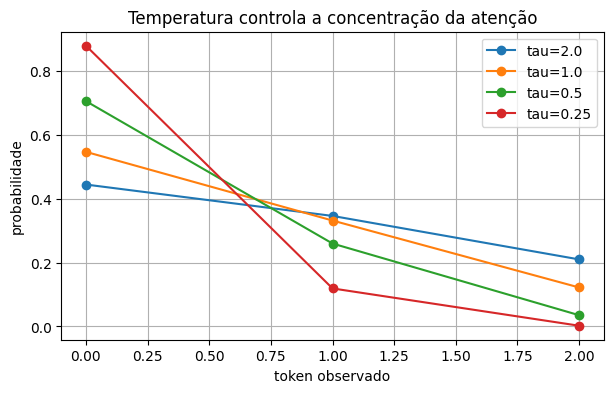

In [ ]:
# -----------------------------
# CÉLULA 8 — Temperatura explícita
# -----------------------------
taus = [2.0, 1.0, 0.5, 0.25]

plt.figure(figsize=(7, 4))
for tau in taus:
    p = softmax(row / tau)
    ent = -(p * torch.log(p + 1e-12)).sum().item()
    print(f"[tau={tau}] softmax={p.cpu().numpy()}  entropy={ent:.4f}")
    plt.plot(p.cpu(), marker="o", label=f"tau={tau}")

plt.title("Temperatura controla a concentração da atenção")
plt.xlabel("token observado")
plt.ylabel("probabilidade")
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
# -----------------------------
# CÉLULA 9 — Por que dividir por √d
# -----------------------------
torch.manual_seed(0)

def random_qk_logits(n=8, dk=64):
    Q = torch.randn(n, dk, device=device)
    K = torch.randn(n, dk, device=device)
    return Q @ K.T

print("\n[ESCALA vs DIMENSÃO]")
for dk in [16, 64, 256, 1024]:
    L = random_qk_logits(dk=dk)
    print(
        f"dk={dk:4d}  "
        f"std(raw)={L.std():.3f}  "
        f"std(scaled)={(L / math.sqrt(dk)).std():.3f}"
    )



[ESCALA vs DIMENSÃO]
dk=  16  std(raw)=3.661  std(scaled)=0.915
dk=  64  std(raw)=9.061  std(scaled)=1.133
dk= 256  std(raw)=15.276  std(scaled)=0.955
dk=1024  std(raw)=29.405  std(scaled)=0.919


In [ ]:
# ============================================================
# PARTE 3 — MIXTURE OF EXPERTS (MoE)
# ============================================================

# -----------------------------
# CÉLULA 10 — FFN denso (baseline)
# -----------------------------
class DenseFFN(nn.Module):
    def __init__(self, d_model=4, d_ff=16):
        super().__init__()
        self.w1 = nn.Linear(d_model, d_ff)
        self.w2 = nn.Linear(d_ff, d_model)
        self.act = nn.GELU()

    def forward(self, x):
        return self.w2(self.act(self.w1(x)))

H = X.clone()  # saída da atenção (didática)
ffn = DenseFFN().to(device)
Y_dense = ffn(H)

print("\n[FFN DENSO] saída:\n", Y_dense)


[FFN DENSO] saída:
 tensor([[-0.1103, -0.0910,  0.1237,  0.0754],
        [-0.2587,  0.3516,  0.1778, -0.1873],
        [-0.3794,  0.3270,  0.1828, -0.2718]], device='cuda:0',
       grad_fn=<AddmmBackward0>)


In [ ]:
# -----------------------------
# CÉLULA 11 — MoE (toy) como substituto do FFN
# -----------------------------
class ToyMoE(nn.Module):
    def __init__(self, d_model=4, d_ff=16, n_experts=4, k=1):
        super().__init__()
        self.k = k
        self.gate = nn.Linear(d_model, n_experts)
        self.experts = nn.ModuleList(
            [DenseFFN(d_model, d_ff) for _ in range(n_experts)]
        )

    def forward(self, x):
        gate_logits = self.gate(x)
        gate_probs = torch.softmax(gate_logits, dim=-1)

        topk_vals, topk_idx = torch.topk(gate_probs, self.k, dim=-1)
        y = torch.zeros_like(x)

        for t in range(x.shape[0]):
            for r in range(self.k):
                e = topk_idx[t, r].item()
                w = topk_vals[t, r]
                y[t] += w * self.experts[e](x[t:t+1]).squeeze(0)

        load = torch.bincount(topk_idx[:, 0], minlength=len(self.experts)).float()
        return y, gate_probs, topk_idx, load

moe = ToyMoE().to(device)
Y_moe, probs, idx, load = moe(H)

print("\n[MoE] saída:\n", Y_moe)
print("[MoE] expert por token:", idx[:, 0].tolist())
print("[MoE] load por expert:", load.tolist())


[MoE] saída:
 tensor([[-0.1432, -0.1279,  0.0061, -0.2159],
        [-0.0554, -0.1806,  0.0984, -0.2173],
        [-0.0511,  0.0100, -0.0435,  0.0121]], device='cuda:0',
       grad_fn=<CopySlices>)
[MoE] expert por token: [1, 1, 3]
[MoE] load por expert: [0.0, 2.0, 0.0, 1.0]


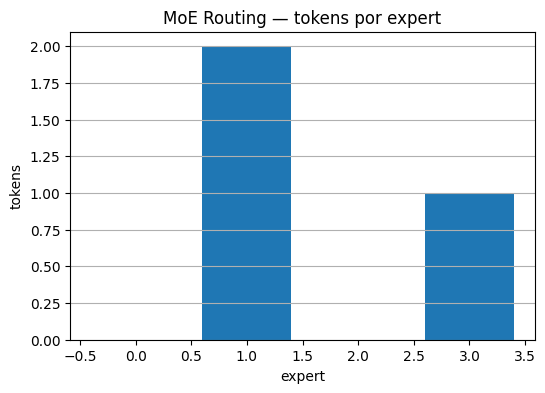

In [ ]:
# -----------------------------
# CÉLULA 12 — Visualização da carga
# -----------------------------
plt.figure(figsize=(6, 4))
plt.bar(range(len(load)), load.cpu())
plt.title("MoE Routing — tokens por expert")
plt.xlabel("expert")
plt.ylabel("tokens")
plt.grid(True, axis="y")
plt.show()


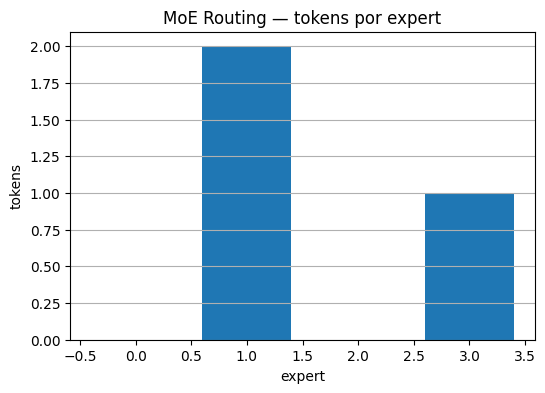

In [ ]:
# -----------------------------
# CÉLULA 12 — Visualização da carga
# -----------------------------
plt.figure(figsize=(6, 4))
plt.bar(range(len(load)), load.cpu())
plt.title("MoE Routing — tokens por expert")
plt.xlabel("expert")
plt.ylabel("tokens")
plt.grid(True, axis="y")
plt.show()
